# DeepWaveAccel simulation

### Load relevent libraries for DeepWaveAccel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav

import Preprocess as pp
import Goertzel as g

### Load and preprocess dataset and training info

In [18]:
# Dataset
Df = pp.DataSet.from_file("/mnt/c/Users/bramh/Documents/UNI git/DeepWave/datasets/FRIDA/dataset/D_1-5_freq0_cold.npz") # proprocessed dataset from DeepWave
Pf = np.load("/mnt/c/Users/bramh/Documents/UNI git/DeepWave/datasets/FRIDA/dataset/D_freq0_train.npz") # trained model parameters

# # Plot the microphone positions in 3D
# XYZ = Df.XYZ # microphone positions
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(XYZ[0], XYZ[1], XYZ[2], c='r', marker='o')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# ax.set_title('Microphone Positions')
# plt.show()

# Load the raw data (wave file)
wav_path = "/mnt/c/Users/bramh/Documents/UNI git/DeepWave/datasets/FRIDA/FRIDA/recordings/20160908/data_pyramic/segmented/two_speakers/1-5.wav"
fs, Draw = wav.read(wav_path)
ff = 1666.66 # Frequency of interest

# Preprocess the dataset
N_ch = Df.XYZ.shape[1] # number of microphones in the array data
N_px = Df.R.shape[1] # number of pixels in the intensity map
N_samples = len(Df) # number of samples in the intensity map
sampler = Df.sampler()


# Decode model parameters and print shapes
K = int(Pf['K']) # Chev filter polynomial order
N_layer = Pf['N_layer'] # number of layers
p_opt = Pf['p_opt'][np.argmin(Pf['v_loss'])]
param = pp.Parameter(48, 2234, 22)
K, B, tau = param.decode(p_opt)
print("Model parameters")
print("K shape: ", K.shape)
print("B shape: ", B.shape)
print("tau shape: ", tau.shape)

# # Plot the parameters
# plt.figure(figsize=(12, 8))
# plt.subplot(3, 1, 1)
# plt.plot(K, label='K')
# plt.title('K')
# plt.subplot(3, 1, 2)
# plt.plot(B[0, :], label='B')
# plt.title('B')
# plt.subplot(3, 1, 3)
# plt.plot(tau, label='tau')
# plt.title('tau')
# plt.tight_layout()
# plt.show()



Model parameters
K shape:  (23,)
B shape:  (48, 2234)
tau shape:  (2234,)


### Time-frequency domain conversion

Frequency of interest:  1666.66
Window size: 200 (12.5 ms)
Selected bin:  21
Frequency of this bin:  1680.0
(56329, 48)
DFT shape:  (281, 48)
Step size:  200


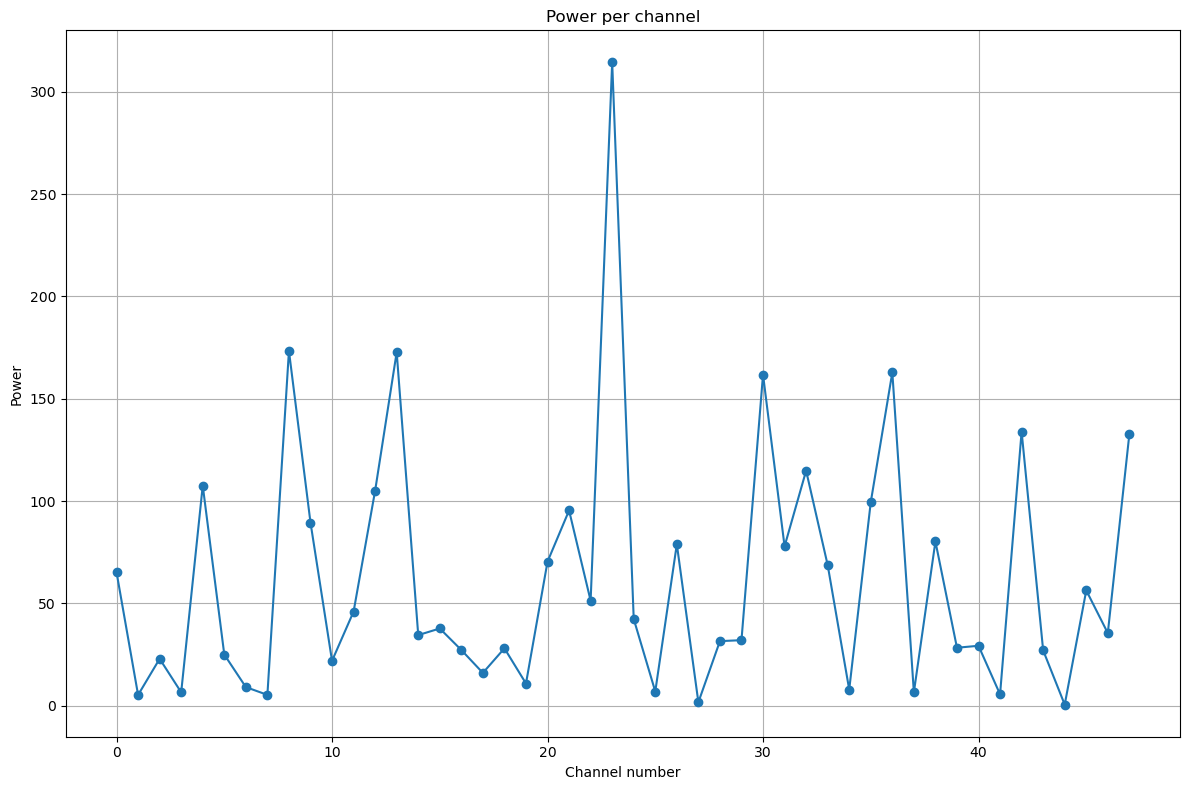

In [54]:
nffloat = 10 * fs / ff # Window size, chosen to contain 10 cycles of the frequency of interest
nf = 200#int(2 ** np.ceil(np.log2(nffloat)))
fr = fs / nf # Frequency resolution per bin [Hz]
bin = round(ff / fr) # Bin number of the frequency of interest
factual = bin * fr # Frequency of the bin [Hz]
print("Frequency of interest: ", ff)
print(f"Window size: {nf} ({nf/fs*1000.0} ms)")
print("Selected bin: ", bin)
print("Frequency of this bin: ", factual)
print(Draw.shape)
dft, step = g.goertzel(Draw, bin, nf, 0.0, True, False)
dft += g.goertzel(Draw, bin-1, nf, 0.0, True, False)[0]
print("DFT shape: ", dft.shape)
print("Step size: ", step)
# print("Goertzel result: ", res)
# Power of frequency bin
P = np.abs(dft) ** 2

# Plot the power per channel
plt.figure(figsize=(12, 8))
plt.plot(np.arange(0, N_ch), P[0,:], 'o-')
plt.title('Power per channel')
plt.xlabel('Channel number')
plt.ylabel('Power')
plt.grid()
plt.tight_layout()
plt.show()



### Cross-correlation matrix

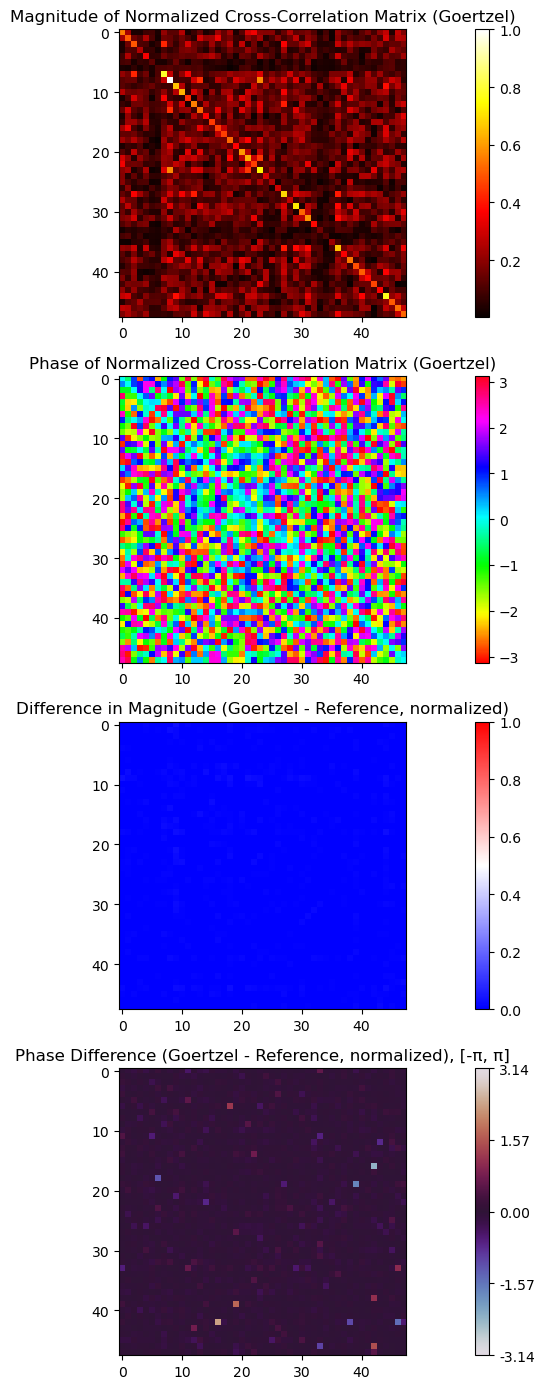

In [73]:
# Compute the cross-correlation matrix using the Goertzel output (res)
# Each entry (i, j) is the correlation between channel i and channel j at the frequency bin of interest

# Calculate and store all correlation matrices using EMA for each frame
alpha = 0.97  # EMA smoothing factor
R = np.zeros((N_ch, N_ch), dtype=np.complex128)
R_all = []  # List to store R at each step

# Calculate and store all correlation matrices using EMA for each frame
for frame in dft:
    outer = np.outer(np.conj(frame), frame)
    R = (1 - alpha) * outer + alpha * R
    R_all.append(R.copy())
R_all = np.stack(R_all)

# Group and sum every 9 resulting correlation matrices
# R_all = R_all[:(R_all.shape[0] // 9) * 9].reshape(-1, 9, N_ch, N_ch).sum(axis=1)



# for frame in dft:
#     outer = np.outer(frame, np.conj(frame))
#     R = (1-alpha) * outer + alpha * R
#     R_all.append(R.copy())
# R_all = np.stack(R_all)

S, _, _ = sampler.decode(Df[0])

# Normalize both the Goertzel and reference cross-correlation matrices before comparison
sel = 8
R_norm = R_all[sel] / np.max(np.abs(R_all[sel]))
S_norm = S / np.max(np.abs(S))

# Display the magnitude and the phase of the normalized cross-correlation matrix (Goertzel)
plt.figure(figsize=(14, 14))
plt.subplot(4, 1, 1)
plt.imshow(np.abs(R_norm), cmap='hot', interpolation='nearest')
plt.title('Magnitude of Normalized Cross-Correlation Matrix (Goertzel)')
plt.colorbar()
plt.subplot(4, 1, 2)
plt.imshow(np.angle(R_norm), cmap='hsv', interpolation='nearest')
plt.title('Phase of Normalized Cross-Correlation Matrix (Goertzel)')
plt.colorbar()

# Compare against normalized DeepWave reference
plt.subplot(4, 1, 3)
diff_mag = np.abs(R_norm) - np.abs(S_norm)
im = plt.imshow(diff_mag, cmap='bwr', interpolation='nearest', vmin=0, vmax=1)
plt.title('Difference in Magnitude (Goertzel - Reference, normalized)')
plt.colorbar(im)

# Show the phase difference (Goertzel - Reference), range -pi to pi
plt.subplot(4, 1, 4)
diff_phase = np.angle(R_norm) - np.angle(S_norm)
diff_phase = (diff_phase + np.pi) % (2 * np.pi) - np.pi  # wrap to [-pi, pi]
plt.imshow(diff_phase, cmap='twilight', interpolation='nearest', vmin=-np.pi, vmax=np.pi)
plt.title('Phase Difference (Goertzel - Reference, normalized), [-π, π]')
plt.colorbar(ticks=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi], format='%.2f')

plt.tight_layout()
plt.show()
